# Create matrix tables 

In this notebook, we prepare matrix tables for use in analysis.

# Setup 

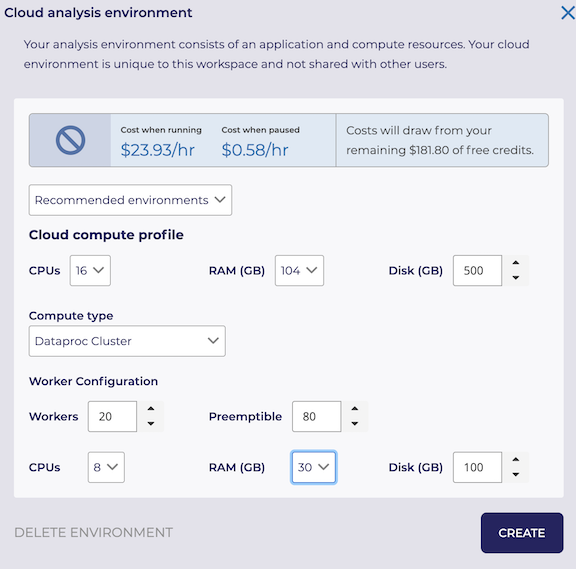

In [ ]:
from datetime import datetime
import hail as hl
import os
import time

## Retrieve exome region file

In [ ]:
!wget -nd biobank.ndph.ox.ac.uk/ukb/ukb/auxdata/xgen_plus_spikein.GRCh38.bed

In [ ]:
!gsutil cp xgen_plus_spikein.GRCh38.bed ${WORKSPACE_BUCKET}/data/ukb/exomes/

## Define constants

In [ ]:
AOU_VCFS = 'gs://fc-aou-preprod-datasets-controlled/5/wgs/vcf/merged/*.vcf.gz'
AOU_MT = f'{os.getenv("WORKSPACE_BUCKET")}/data/aou/alpha1/cohort.mt'

UKB_VCFS = 'gs://fc-7130e767-a885-4678-95ed-7c966c79e2d0/200K/pvcf/ukb23156_*.vcf.gz'

EXOME_REGIONS = f'{os.getenv("WORKSPACE_BUCKET")}/data/ukb/exomes/xgen_plus_spikein.GRCh38.bed'

In [ ]:
RESULT_BUCKET = os.getenv("WORKSPACE_BUCKET")
DATESTAMP = time.strftime('%Y%m%d')
TIMESTAMP = time.strftime('%Y%m%d_%H%M%S')
WORK_DIR = !pwd

# Output files
UKB_MT = f'{os.getenv("WORKSPACE_BUCKET")}/data/ukb/exomes/full_dataset.mt'
HAIL_LOG = f'{WORK_DIR[0]}/hail-make-mt-{TIMESTAMP}.log'
HAIL_LOG_DIR_FOR_PROVENANCE = f'{os.getenv("WORKSPACE_BUCKET")}/hail-logs/{DATESTAMP}/'

## Check access

In [ ]:
!gsutil ls {AOU_VCFS} | head

In [ ]:
!gsutil ls {UKB_VCFS}

# Start Hail 

In [ ]:
EXTRA_SPARK_CONFIG = {
    'spark.driver.extraJavaOptions': '-Xss4M',
    'spark.driver.maxResultSize': '50G',
    'spark.driver.memory': '90G',
    'spark.executor.extraJavaOptions': '-Xss4M',
    'spark.kryoserializer.buffer.max': '1G',
    'spark.memory.fraction': '0.33',
    'spark.network.timeout': '300',
    'spark.speculation': 'true',
    'spark.speculation.quantile': '0.95',
    'spark.task.maxFailures': '20'
}

In [ ]:
hl.init(spark_conf=EXTRA_SPARK_CONFIG,
        min_block_size=50,
        default_reference='GRCh38',
        log=HAIL_LOG)

# Load exome capture regions

In [ ]:
ukb_exome_capture_regions = hl.import_bed(EXOME_REGIONS)

In [ ]:
ukb_exome_capture_regions.describe()

In [ ]:
ukb_exome_capture_regions.show(5)

# Create AoU matrix table

<div class="alert alert-block alert-info">
<b>Note:</b> The AoU matrix table for the alpha1 release was created via notebook 'Hail Demo' and then moved to a better place within the workspace bucket.
</div>

In [ ]:
!gsutil ls {AOU_MT}

# Create UKB exomes matrix table

In [ ]:
ukb_exomes = hl.import_vcf(UKB_VCFS,
                           array_elements_required=False,
                           force_bgz=True)

In [ ]:
ukb_exomes.describe()

In [ ]:
ukb_exomes = ukb_exomes.filter_rows(
    hl.is_defined(ukb_exome_capture_regions[ukb_exomes.locus]))

In [ ]:
start = datetime.now()
print(start)

In [ ]:
ukb_exomes.write(UKB_MT, overwrite=True)

In [ ]:
end = datetime.now()
print(end)
print(end - start)

In [ ]:
!gsutil ls {UKB_MT}

# Provenance

In [ ]:
# Copy the Hail log to the workspace bucket so that we can retain it.
!gsutil cp {HAIL_LOG} {HAIL_LOG_DIR_FOR_PROVENANCE}

In [ ]:
print(datetime.now())

In [ ]:
!pip3 freeze